# Image generation

In Part 1 of this course, we focused mainly on models that were useful for classification. However, many applications require generating much higher dimensional results, such as images and sentences. Examples include:
* Text: neural translation, text to speech, image captioning
* Image: Segmentation, artistic filters, image sharpening and cleaning

In [4]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from utils2 import limit_mem
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

In [5]:
# Tell Tensorflow to use no more GPU RAM than necessary
limit_mem()


Data can be downloaded from [here](http://files.fast.ai/data/imagenet-sample-train.tar.gz). Update path below to where you download data to. Optionally use a 2nd path for fast (e.g. SSD) storage - set both to the same path if using AWS.

In [6]:
# path = '/data/datasets/imagenet/sample/'
# dpath = '/data/jhoward/fast/imagenet/sample/'
path = 'data/'

## Neural style transfer

The first use case of an image to image architecture we're going to look at is neural style transfer, using the approach in [this paper](https://arxiv.org/abs/1508.06576). This is a fairly popular application of deep learning in which an image is recreated in the style of a work of art, such as Van Gogh's Starry Night. For more information about the use of neural networks in art, see this [Scientific American article](https://blogs.scientificamerican.com/sa-visual/neural-networks-for-artists/) or [Google's Magenta Project](https://magenta.tensorflow.org/welcome-to-magenta).

### Setup

Our first step is to list out the files we have, and then grab some image.

In [7]:
fnames = glob.glob(path+'**/*256.jpg', recursive=True)
n = len(fnames); n

2

In [8]:
# fn = fnames[50]; fn
fn = fnames[0]

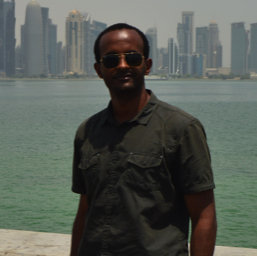

In [9]:
img=Image.open(fn); img

That's a nice looking image! Feel free to use any other image that you're interested in playing with.

We'll be using this image with VGG16. Therefore, we need to subtract the mean of each channel of the imagenet data and reverse the order of RGB->BGR since those are the preprocessing steps that the VGG authors did - so their model won't work unless we do the same thing.

We can do this in one step using *broadcasting*, which is a topic we'll be returning to many times during this course.

In [10]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

When we generate images from this network, we'll need to undo the above preprocessing in order to view them.

In [11]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [12]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

#### Broadcasting examples

In [18]:
np.array([1,2,3]) - 2

array([-1,  0,  1])

In [19]:
np.array([2,3]).reshape(1,1,1,2)

array([[[[2, 3]]]])

In [20]:
np.array([2,3]).reshape(1,1,2,1)

array([[[[2],
         [3]]]])

In [21]:
a = np.random.randn(5,1,3,2)
b = np.random.randn(2)
(a-b).shape

(5, 1, 3, 2)

### Recreate input

The first step in style transfer is understanding how to recreate an image from noise based on "content loss", which is the amount of difference between activations in some layer. In earlier layes, content loss is very similar to per-pixel loss, but in later layers it is capturing the "meaning" of a part of an image, rather than the specific details.

To do this, we first take a CNN and pass an image through it. We then pass a "noise image" (i.e. random pixel values) through the same CNN. At some layer, we compare the outputs from it for both images. We then use a MSE to compare the activations of these two outputs. 

The interesting part is that now, instead of updating the parameters of the CNN, we update the pixels of the noisy image. In other words, our goal is to alter the noisy image so as to minimize the difference between the original image's output at some convolutional layer with the output of the noisy image at the same layer.

In order to construct this architecture, we're going to be working with keras.backend, which is an abstraction layer that allows us to target both theano and tensorflow with the same code.

The CNN we'll use is VGG16, but with a twist. Previously we've always used Vgg with max pooling, and this was useful for image classification. It's not as useful in this case however, because max pooling loses information about the original input area. Instead we will use average pooling, as this does not throw away as much information.

In [ ]:
model = VGG16_Avg(require_flatten=False)

Here we're grabbing the activations from near the end of the convolutional model).

In [57]:
layer = model.get_layer('block5_conv1').output

And let's calculate the target activations for this layer:

In [58]:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In our implementation, we need to define an object that will allow us to separately access the loss function and gradients of a function, since that is what scikit-learn's optimizers require.

In [22]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

We'll define our loss function to calculate the mean squared error between the two outputs at the specified convolutional layer.

In [23]:
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

NameError: name 'layer' is not defined

Now we're going to optimize this loss function with a deterministic approach to optimization that uses a line search, which we can implement with sklearn's `fmin_l_bfgs_b` funtionc. 

In [24]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

In [44]:
??fmin_l_bfgs_b


Next we need to generate a random image.

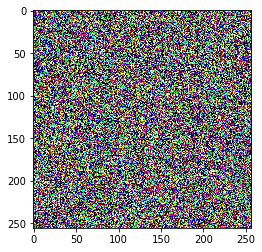

In [17]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

Now we'll run through this optimization approach ten times and train the noise image's pixels as desired.

In [46]:
iterations=20

In [ ]:
x = solve_image(evaluator, iterations, x)

Our result by comparing output at conv 1 of last block (5) is fairly amorphous, but still easily recognizable as a bird. Notice that the things it has reconstructed particularly well are those things that we expect Vgg16 to be good at recognizing, such as an eye or a beak.

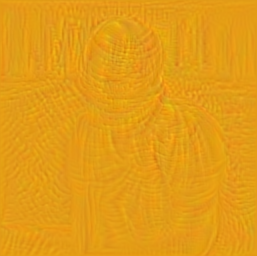

In [24]:
Image.open('results/res_at_iteration_9.png')

If instead we optimized by calculating loss from the output of conv 1 of 4th block, our trained image looks much more like the original. This makes sense because with less transformations to go through, comparing at an earlier layer means that we have a smaller receptive field and the features are more based on geometric details rather than broad features.

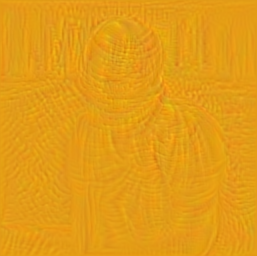

In [25]:
Image.open('results/res_at_iteration_9.png')

In [26]:
from IPython.display import HTML
from matplotlib import animation, rc

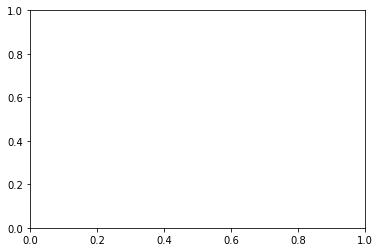

In [27]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'results/res_at_iteration_{i}.png'))

The optimizer first focuses on the important details of the bird, before trying to match the background.

In [ ]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

### Recreate style

Now that we've learned how to recreate an input image, we'll move onto attempting to recreate *style*. By "style", we mean the color palette and texture of an image. Unlike recreating based on content, with style we are not concerned about the actual structure of what we're creating, all we care about is that it captures this concept of "style".

Here are some examples of images we can extract style from.

In [14]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

In [50]:
style = Image.open('data/starry_night_256.jpg')
style = style.resize(np.divide(style.size,2).astype('int32')); style.size

(250, 249)

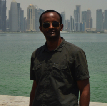

In [49]:
style = Image.open('data/eliasq_256.jpg')
style = style.resize(np.divide(style.size,2.4).astype('int32')); style

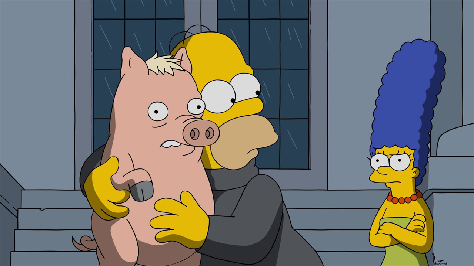

In [349]:
style = Image.open('data/simpsons.jpg')
style = style.resize(np.divide(style.size,2.7).astype('int32')); style

We're going to repeat the same approach as before, but with some differences.

In [59]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape
shp

(1, 249, 250, 3)

In [60]:
model = VGG16_Avg(require_flatten=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

/Users/EH/projects/courses/deeplearning2/vgg16_avg.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/Users/EH/projects/courses/deeplearning2/vgg16_avg.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/Users/EH/projects/courses/deeplearning2/vgg16_avg.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Conv2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/Users/EH/projects/courses/deeplearning2/vgg16_avg.py:54: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="

In [73]:

def content_loss(computed, target, weight_ls=None):
    if isinstance(computed, list):
        if not weight_ls:
            weight_ls = [1.0 for layer in computed]
        #end
        c_loss = sum([K.sum(metrics.mse(comp[0], targ[0]) * w \
                      for comp, targ, w in zip(computed, target, weight_ls))])
        _, height, width, channels = map(lambda i: i, K.int_shape(computed[0]))
    else:
        c_loss = K.sum(metrics.mse(computed, target))
        _, height, width, channels = K.int_shape(computed)
    #end
    c_loss = c_loss #/ (height * width * channels)
    return c_loss
#end

def style_loss(computed, target, weight_ls=None):
    if isinstance(computed, list):
        if not weight_ls:
            weight_ls = [1.0 for layer in computed]
        #end
        s_loss = sum([K.sum(metrics.mse(gram_matrix(comp[0]), gram_matrix(targ[0]))) * w \
                      for comp, targ, w in zip(computed, target, weight_ls)])
        _, height, width, channels = map(lambda i: i, K.int_shape(computed[0]))
    else:
        s_loss = K.sum(metrics.mse(gram_matrix(computed), gram_matrix(target)))
        _, height, width, channels = K.int_shape(computed)
    #end
    s_loss = s_loss #/ (height * width * channels)
    return s_loss

# c_loss = content_loss(layer, targ)
s_loss = style_loss(layers, targs, style_wgts)

One thing to notice is that we're actually going to be calculating the loss function multiple layers, rather than just one. (Note however that there's no reason you couldn't try using multiple layers in your content loss function, if you wanted to try that).

In [61]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [62]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

The key difference is our choice of loss function. Whereas before we were calculating mse of the raw convolutional outputs, here we transform them into the "gramian matrix" of their channels (that is, the product of a matrix and its transpose) before taking their mse. It's unclear why this helps us achieve our goal, but it works. One thought is that the gramian  shows how our features at that convolutional layer correlate, and completely removes all location information. So matching the gram matrix of channels can only match some type of texture information, not location information.

In [63]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [64]:
def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [75]:
# loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
loss = style_loss(layers, targs, style_wgts)
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

We then solve as we did before.

In [76]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

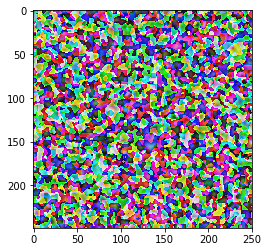

In [77]:
plt.imshow(x[0]);

In [84]:
iterations=15
x = rand_img(shp)

In [85]:
x = solve_image(evaluator, iterations, x)

Current loss value: 103557.046875
Current loss value: 7303.828125
Current loss value: 2081.55371094
Current loss value: 1164.14221191
Current loss value: 809.79510498
Current loss value: 625.205200195
Current loss value: 515.275085449
Current loss value: 421.89730835
Current loss value: 349.95703125
Current loss value: 294.815093994
Current loss value: 253.847793579
Current loss value: 217.790908813
Current loss value: 192.05531311
Current loss value: 164.336715698
Current loss value: 143.037597656


Our results are stunning. By transforming the convolutional outputs to the gramian, we are somehow able to update the noise pixels to produce an image that captures the raw style of the original image, with absolutely no structure or meaning.

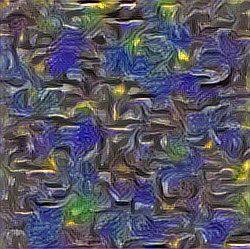

In [86]:
Image.open('results/res_at_iteration_4.png')

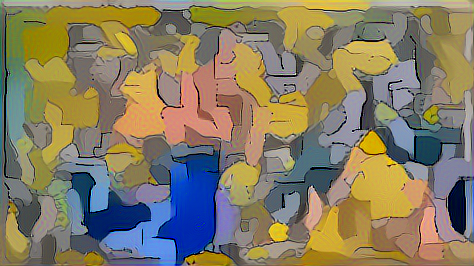

In [801]:
Image.open(path + 'res_at_iteration_9.png')

### Style transfer

We now know how to reconstruct an image, as well as how to construct an image that captures the style of an original image. The obvious idea may be to just combine these two approaches by weighting and adding the two loss functions.

(249, 250)

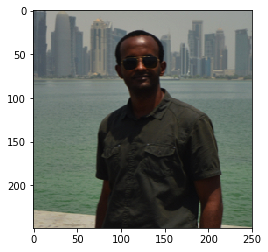

In [87]:
w,h = style.size
src = img_arr[:,:h,:w]
plot_arr(src)
h,w

Like before, we're going to grab a sequence of layer outputs to compute the style loss. However, we still only need one layer output to compute the content loss. How do we know which layer to grab? As we discussed earlier, the lower the layer, the more exact the content reconstruction will be. In merging content reconstruction with style, we might expect that a looser reconstruction of the content will allow more room for the style to have an effect (re: inspiration). Furthermore, a later layer ensures that the image "looks like" the same subject, even if it doesn't have the same details.

In [88]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [89]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [90]:
model.input.shape

TensorShape([Dimension(None), Dimension(249), Dimension(250), Dimension(3)])

In [91]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

Now to actually merge the two approaches is as simple as merging their respective loss functions. Note that as opposed to our previous to functions, this function is producing three separate types of outputs: one for the original image, one for the image whose style we're emulating, and one for the random image whose pixel's we are training. 

One way for us to tune how the reconstructions mix is by changing the factor on the content loss, which we have here as 1/10. If we increase that denominator, the style will have a larger effect on the image, and if it's too large the original content of the image will be obscured by unstructured style. Likewise, if it is too small than the image will not have enough style.

In [92]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [41]:
def content_loss(computed, target, weight_ls=None):
    if isinstance(computed, list):
        if not weight_ls:
            weight_ls = [1.0 for layer in computed]
        #end
        c_loss = sum([K.sum(metrics.mse(comp[0], targ[0]) * w \
                      for comp, targ, w in zip(computed, target, weight_ls))])
        _, height, width, channels = map(lambda i: i, K.int_shape(computed[0]))
    else:
        c_loss = K.sum(metrics.mse(computed, target))
        _, height, width, channels = K.int_shape(computed)
    #end
    c_loss = c_loss #/ (height * width * channels)
    return c_loss
#end

def style_loss(computed, target, weight_ls=None):
    if isinstance(computed, list):
        if not weight_ls:
            weight_ls = [1.0 for layer in computed]
        #end
        s_loss = sum([K.sum(metrics.mse(gram_matrix(comp[0]), gram_matrix(targ[0]))) * w \
                      for comp, targ, w in zip(computed, target, weight_ls)])
        _, height, width, channels = map(lambda i: i, K.int_shape(computed[0]))
    else:
        s_loss = K.sum(metrics.mse(gram_matrix(computed), gram_matrix(target)))
        _, height, width, channels = K.int_shape(computed)
    #end
    s_loss = s_loss #/ (height * width * channels)
    return s_loss

# c_loss = content_loss(layer, targ)
s_loss = style_loss(layers, targs, style_wgts)

In [93]:
# loss = sum(style_loss(l1[0], l2[0])*w
#            for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss = style_loss(layers, targs, style_wgts)
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [94]:
evaluator = Evaluator(transfer_fn, shp)

In [97]:
iterations=5
x = rand_img(shp)

In [96]:
x = solve_image(evaluator, iterations, x)

Current loss value: [[[ 406300.75     406320.46875  406340.15625  406270.75     406228.71875
    406220.125    406254.90625  406242.21875  406223.875    406226.40625
    406246.34375  406262.59375  406254.96875  406281.03125  406372.28125
    406383.25     406346.03125  406366.0625   406310.6875   406217.125
    406188.09375  406192.28125  406206.40625  406226.46875  406209.65625
    406209.625    406194.40625  406207.1875   406229.28125  406227.71875
    406179.78125]
  [ 406272.625    406213.78125  406247.875    406234.375    406224.125
    406205.21875  406214.09375  406254.6875   406251.5625   406322.3125
    406258.65625  406255.71875  406296.       406396.75     406562.
    406610.5625   406473.34375  406384.375    406341.90625  406308.625
    406251.15625  406194.90625  406198.1875   406255.65625  406215.40625
    406185.53125  406156.84375  406173.65625  406183.78125  406200.09375
    406180.625  ]
  [ 406243.03125  406193.1875   406209.46875  406213.71875  406243.3125
    4062

Current loss value: [[[ 341209.96875  341227.9375   341246.53125  341172.96875  341134.46875
    341125.25     341159.65625  341150.25     341133.5      341138.0625
    341158.59375  341170.28125  341166.21875  341193.6875   341278.3125
    341293.03125  341255.9375   341284.8125   341227.1875   341123.875
    341094.09375  341098.9375   341117.8125   341140.28125  341118.6875
    341116.53125  341100.6875   341113.5625   341136.09375  341131.4375
    341085.03125]
  [ 341178.71875  341118.53125  341156.71875  341140.09375  341131.59375
    341112.0625   341119.0625   341161.5      341159.5625   341231.875
    341168.5      341164.5625   341205.59375  341308.40625  341472.84375
    341523.3125   341382.84375  341297.65625  341254.71875  341217.03125
    341159.21875  341102.0625   341109.84375  341168.34375  341124.9375
    341090.84375  341062.03125  341078.0625   341090.625    341103.34375
    341084.     ]
  [ 341148.8125   341096.84375  341114.6875   341120.       341148.3125
    3

Current loss value: [[[ 298105.03125  298122.21875  298140.6875   298063.3125   298028.1875
    298018.65625  298053.15625  298045.375    298030.09375  298035.6875
    298057.09375  298065.0625   298063.53125  298091.25     298172.28125
    298188.9375   298153.53125  298188.90625  298129.       298018.21875
    297987.53125  297993.15625  298014.84375  298039.3125   298014.40625
    298011.21875  297994.6875   298006.15625  298030.03125  298023.40625
    297978.78125]
  [ 298072.       298010.84375  298053.4375   298034.3125   298027.
    298006.65625  298012.375    298056.125    298055.03125  298127.8125
    298064.84375  298059.90625  298100.0625   298205.5      298370.46875
    298423.875    298279.375    298197.46875  298153.65625  298112.0625
    298053.78125  297997.03125  298007.71875  298066.6875   298021.59375
    297984.875    297955.375    297970.40625  297985.59375  297995.59375
    297976.21875]
  [ 298042.03125  297988.46875  298008.875    298014.84375  298043.03125
    

Current loss value: [[[ 264713.09375  264729.4375   264748.09375  264667.09375  264634.84375
    264625.4375   264659.71875  264653.15625  264639.90625  264645.875
    264668.3125   264673.0625   264673.4375   264701.0625   264779.65625
    264798.5      264763.53125  264805.03125  264743.3125   264625.75
    264594.5625   264600.8125   264624.5625   264650.625    264623.15625
    264619.0625   264602.5      264611.71875  264637.3125   264629.09375
    264586.5    ]
  [ 264678.75     264616.71875  264663.96875  264641.875    264635.375
    264614.375    264619.53125  264663.84375  264663.5625   264736.375
    264674.375    264668.34375  264706.71875  264815.21875  264981.21875
    265037.375    264888.96875  264810.03125  264765.78125  264720.1875
    264661.5625   264605.125    264617.84375  264677.75     264632.09375
    264592.375    264562.25     264576.375    264594.34375  264601.46875
    264582.53125]
  [ 264649.28125  264593.875    264617.53125  264623.625    264652.15625
    2

Current loss value: [[[ 239150.875     239166.71875   239185.609375  239101.34375   239071.09375
    239062.6875    239096.859375  239090.734375  239079.625     239085.375
    239108.        239110.515625  239112.40625   239139.96875
    239216.796875  239237.125     239203.109375  239249.40625   239186.15625
    239063.125     239031.5625    239038.234375  239063.25      239090.734375
    239061.375     239057.        239040.3125    239047.296875  239075.1875
    239064.953125  239024.296875]
  [ 239115.28125   239053.359375  239104.984375  239079.3125    239073.5625
    239051.546875  239057.375     239101.671875  239101.5625    239174.3125
    239113.3125    239106.640625  239142.671875  239252.8125    239421.46875
    239479.15625   239328.546875  239251.875     239207.4375    239158.03125
    239098.953125  239042.984375  239057.        239118.125     239072.796875
    239030.15625   238999.390625  239012.3125    239032.734375
    239037.34375   239018.90625 ]
  [ 239086.953125  2

Current loss value: [[[ 218192.9375    218208.40625   218228.546875  218140.296875
    218111.203125  218103.453125  218137.84375   218132.3125    218123.078125
    218128.046875  218150.625     218151.296875  218154.421875
    218182.796875  218258.625     218280.0625    218246.90625
    218296.921875  218232.015625  218104.671875  218072.859375
    218079.640625  218105.75      218134.78125   218103.890625
    218099.28125   218082.6875    218087.296875  218117.625     218105.4375
    218066.859375]
  [ 218156.234375  218094.921875  218151.625     218121.078125  218115.6875
    218092.5625    218099.921875  218144.        218143.109375  218215.
    218155.71875   218148.140625  218182.0625    218293.578125
    218465.59375   218527.        218372.90625   218298.390625  218253.1875
    218200.1875    218140.234375  218085.09375   218099.84375
    218162.453125  218117.5625    218072.109375  218040.984375
    218052.734375  218075.5       218077.828125  218059.5625  ]
  [ 218129.71875 

Current loss value: [[[ 199523.984375  199539.640625  199561.4375    199468.296875
    199439.890625  199433.453125  199466.921875  199462.953125
    199455.640625  199459.3125    199482.09375   199480.5       199485.046875
    199515.515625  199590.6875    199613.703125  199579.734375
    199634.203125  199567.90625   199435.875     199403.328125
    199410.203125  199437.046875  199467.125     199435.5625    199430.578125
    199414.875     199416.984375  199450.125     199435.5625    199399.421875]
  [ 199486.78125   199426.609375  199489.5625    199452.34375
    199446.390625  199422.546875  199431.609375  199475.6875    199473.609375
    199544.015625  199487.0625    199477.765625  199509.6875    199623.296875
    199797.875     199866.609375  199706.703125  199635.875     199589.359375
    199531.609375  199470.1875    199415.9375    199430.890625
    199495.28125   199451.515625  199403.3125    199372.03125
    199382.609375  199406.890625  199407.609375  199389.328125]
  [ 1994

Current loss value: [[[ 181912.796875  181929.25      181953.6875    181853.859375
    181824.921875  181820.546875  181851.75      181850.546875
    181845.796875  181846.90625   181870.046875  181866.5       181872.328125
    181905.84375   181979.546875  182004.09375   181968.984375
    182028.609375  181961.96875   181824.6875    181790.75      181797.921875
    181824.375     181856.109375  181824.515625  181819.484375
    181804.609375  181803.734375  181841.953125  181824.328125
    181790.234375]
  [ 181876.078125  181817.546875  181888.046875  181842.21875
    181834.140625  181809.25      181820.71875   181863.3125    181859.640625
    181928.875     181874.375     181863.34375   181893.15625
    182009.671875  182186.328125  182266.046875  182099.171875  182031.3125
    181982.96875   181919.90625   181856.953125  181803.078125
    181818.09375   181884.453125  181842.921875  181791.65625   181760.65625
    181769.828125  181795.71875   181795.09375   181776.671875]
  [ 1818

Current loss value: [[[ 163481.078125  163499.1875    163526.984375  163418.359375
    163388.765625  163386.796875  163413.765625  163415.5       163415.640625
    163412.6875    163436.6875    163430.40625   163437.609375  163477.3125
    163548.453125  163575.875     163538.09375   163602.953125
    163536.765625  163392.828125  163356.6875    163363.640625  163388.125
    163422.65625   163392.234375  163388.734375  163375.59375   163371.34375
    163416.90625   163394.65625   163363.3125  ]
  [ 163446.375     163389.75      163471.625     163411.765625
    163400.015625  163373.640625  163388.34375   163428.546875
    163421.578125  163490.34375   163439.765625  163426.890625
    163453.59375   163573.59375   163755.171875  163853.671875  163673.375
    163605.859375  163556.828125  163487.390625  163421.1875    163367.390625
    163381.765625  163450.671875  163413.59375   163358.890625  163329.1875
    163336.453125  163363.84375   163362.3125    163344.53125 ]
  [ 163424.671875

Current loss value: [[[ 133017.859375  133038.03125   133069.265625  132946.21875
    132915.234375  132915.984375  132933.484375  132938.53125
    132950.453125  132937.390625  132963.390625  132951.625     132962.796875
    133026.65625   133087.71875   133120.5625    133078.828125
    133147.53125   133080.28125   132924.015625  132882.15625
    132890.171875  132907.375     132948.078125  132921.546875
    132925.390625  132917.703125  132907.28125   132973.015625
    132937.859375  132912.359375]
  [ 132984.578125  132939.84375   133043.84375   132947.59375   132925.5625
    132895.703125  132914.5625    132950.640625  132938.75      133007.3125
    132964.734375  132946.140625  132965.453125  133098.6875    133291.625
    133442.078125  133227.        133151.875     133099.53125   133019.0625
    132940.078125  132887.        132899.765625  132974.171875  132943.5
    132885.171875  132862.296875  132864.421875  132894.296875
    132893.71875   132879.875   ]
  [ 132966.15625   1

These results are remarkable. Each does a fantastic job at recreating the original image in the style of the artist.

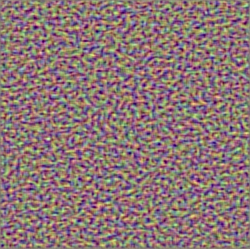

In [104]:
Image.open('results/res_at_iteration_3.png')

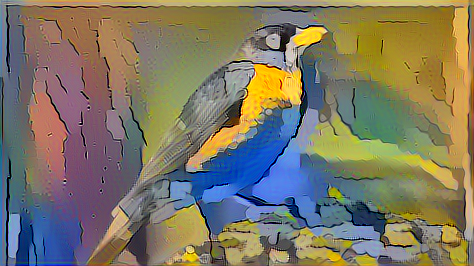

In [932]:
Image.open(path + 'res_at_iteration_9.png')

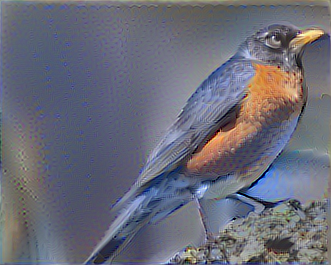

In [914]:
Image.open(path + 'res_at_iteration_9.png')

There are lots of interesting additional things you could try, such as the ideas shown here: https://github.com/titu1994/Neural-Style-Transfer .

## Use content loss to create a super-resolution network

So far we've demonstrated how to achieve succesful results in style transfer. However, there is an obvious drawback to our implementation, namely that we're training an image, not a network, and therefore every new image requires us to retrain. It's not a feasible method for any sort of real-time application. Fortunately we can adress this issue by using a fully convolutional network (FCN), and in particular we'll look at this implementation for Super resolution. We are following the approach in [this paper](https://arxiv.org/abs/1603.08155).

In [7]:
arr_lr = bcolz.open(dpath+'trn_resized_72_r.bc')[:]
arr_hr = bcolz.open(dpath+'trn_resized_288_r.bc')[:]

KeyboardInterrupt: 

In [ ]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

To start we'll define some of the building blocks of our network. In particular recall the residual block (as used in [Resnet](https://arxiv.org/abs/1512.03385)), which is just a sequence of 2 convolutional layers that is added to the initial block input. We also have a de-convolutional layer (also known as a "transposed convolution" or "fractionally strided convolution"), whose purpose is to learn to "undo" the convolutional function. It does this by padding the smaller image in such a way to apply filters on it to produce a larger image.

In [ ]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

In [ ]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

In [ ]:
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, 
        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

In [ ]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

This model here is using the previously defined blocks to encode a low resolution image and then upsample it to match the same image in high resolution.

In [737]:
inp=Input(arr_lr.shape[1:])
x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

The method of training this network is almost exactly the same as training the pixels from our previous implementations. The idea here is we're going to feed two images to Vgg16 and compare their convolutional outputs at some layer. These two images are the target image (which in our case is the same as the original but at higher resolution), and the output of the previous network we just defined, which we hope will learn to output a high resolution image. 

The key then is to train this other network to produce an image that minimizes the loss between the outputs of some convolutional layer in Vgg16 (which the paper refers to as "perceptual loss"). In doing so, we are able to train a network that can upsample an image and recreate the higher resolution details.

In [ ]:
vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

Since we only want to learn the "upsampling network", and are just using VGG to calculate the loss function, we set the Vgg layers to not be trainable.

In [ ]:
for l in vgg.layers: l.trainable=False

An important difference in training for super resolution is the loss function. We use what's known as a perceptual loss function (which is simply the content loss for some layer). 

In [ ]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv1').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [ ]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [ ]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [743]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((arr_hr.shape[0], 1))

Finally we compile this chain of models and we can pass it the original low resolution image as well as the high resolution to train on. We also define a zero vector as a target parameter, which is a necessary parameter when calling fit on a keras model.

In [744]:
m_sr.compile('adam', 'mse')
m_sr.fit([arr_lr, arr_hr], targ, 8, 2, **parms)

We use learning rate annealing to get a better fit.

In [745]:
K.set_value(m_sr.optimizer.lr, 1e-4)
m_sr.fit([arr_lr, arr_hr], targ, 16, 1, **parms)

We are only interested in the trained part of the model, which does the actual upsampling.

In [746]:
top_model = Model(inp, outp)

In [747]:
p = top_model.predict(arr_lr[10:11])

After training for some time, we get some very impressive results! Look at these two images, we can see that the predicted higher resolution image has filled in a lot of detail, including the shadows under the greens and the texture of the food.

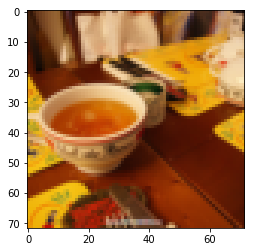

In [267]:
plt.imshow(arr_lr[10].astype('uint8'));

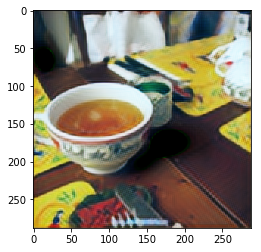

In [748]:
plt.imshow(p[0].astype('uint8'));

In [749]:
top_model.save_weights(dpath+'sr_final.h5')

In [198]:
top_model.load_weights(dpath+'top_final.h5')

The important thing to take away here is that as opposed to our earlier approaches, this type of approach results in a model that can created the desired image and is a scalable implementation.

Note that we haven't used a test set here, so we don't know if the above result is due to over-fitting. As part of your homework, you should create a test set, and try to train a model that gets the best result you can on the test set.

## Fast style transfer

The original paper showing the above approach to super resolution also used this approach to create a much faster style transfer system (for a specific style). Take a look at [the paper](https://arxiv.org/abs/1603.08155) and the very helpful [supplementary material](http://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16Supplementary.pdf). Your mission, should you choose to accept it, it to modify the super resolution example above to do fast style transfer based on this paper. 

### Reflection padding

The supplementary material mentions that that found reflection padding helpful - we have implemented this as a keras layer for you. All the other layers and blocks are already defined above.

(This is also a nice simple example of a custom later that you can refer to when creating your own custom layers in the future.)

In [4]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

Testing the reflection padding layer:

In [5]:
inp = Input((288,288,3))
ref_model = Model(inp, ReflectionPadding2D((40,10))(inp))
ref_model.compile('adam', 'mse')

In [13]:
p = ref_model.predict(arr_hr[10:11])

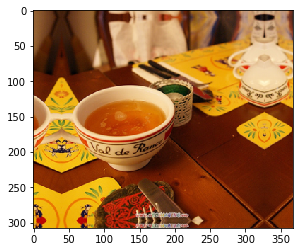

In [14]:
plt.imshow(p[0].astype('uint8'));

### Main algorithm

This approach is exactly the same as super resolution, except now the loss includes the style loss.

In [ ]:
shp = arr_hr.shape[1:]

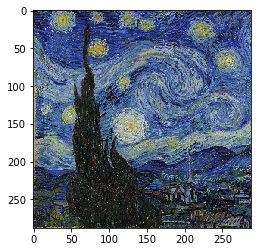

In [38]:
style = Image.open('data/starry_night.jpg')
style = style.resize(np.divide(style.size,3.5).astype('int32'))
style = np.array(style)[:shp[0], :shp[1], :shp[2]]
plt.imshow(style);

In [39]:
def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')

In [40]:
inp=Input(shp)
x=ReflectionPadding2D((40, 40))(inp)
x=conv_block(x, 64, 9, (1,1))
x=conv_block(x, 64, 3)
x=conv_block(x, 64, 3)
for i in range(5): x=res_crop_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

In [41]:
vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [42]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])

Here we alter the super resolution approach by adding style outputs

In [43]:
style_targs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style,0))]

In [44]:
[K.eval(K.shape(o)) for o in style_targs]

[array([  1, 144, 144, 128], dtype=int32),
 array([  1,  72,  72, 256], dtype=int32),
 array([  1,  36,  36, 512], dtype=int32),
 array([  1,  18,  18, 512], dtype=int32)]

In [45]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

Our loss now includes the mse for the content loss and the gram matrix for the style

In [46]:
def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))

In [47]:
w=[0.1, 0.2, 0.6, 0.1]
def tot_loss(x):
    loss = 0; n = len(style_targs)
    for i in range(n):
        loss += mean_sqr_b(gram_matrix_b(x[i+n]) - gram_matrix_b(style_targs[i])) / 2.
        loss += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return loss

In [48]:
loss = Lambda(tot_loss)(vgg1+vgg2)
m_style = Model([inp, vgg_inp], loss)
targ = np.zeros((arr_hr.shape[0], 1))

In [ ]:
m_style.compile('adam', 'mae')
m_style.fit([arr_hr, arr_hr], targ, 8, 2, **parms)

In [732]:
K.set_value(m_style.optimizer.lr, 1e-4)
m_style.fit([arr_hr, arr_hr], targ, 16, 1, **parms)

In [49]:
top_model = Model(inp, outp)

Now we can pass any image through this CNN and it will produce it in the style desired!

In [54]:
p = top_model.predict(arr_hr[:20])

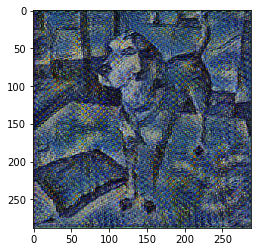

In [69]:
plt.imshow(np.round(p[1]).astype('uint8'));

In [736]:
top_model.save_weights(dpath+'style_final.h5')

In [50]:
top_model.load_weights(dpath+'style_final.h5')

## Next steps

Here's some ideas for things to try:
- https://github.com/junyanz/iGAN
- https://arxiv.org/abs/1605.04603
- https://arxiv.org/abs/1606.05897
- http://cs231n.stanford.edu/reports2016/208_Report.pdf